In [0]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


connect to google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

os.getcwd()
os.chdir('/content')
os.getcwd()
# help(pd.read_csv)

'/content'

we set train size=1000000, and drop the case: fare amount<=0

In [0]:
TRAIN_PATH = 'drive/My Drive/train.csv'
TEST_PATH = 'drive/My Drive/test.csv'
DATASET_SIZE = 1000000
# datatypes = {'key': 'str', 
#               'fare_amount': 'float32',
#               'pickup_datetime': 'str', 
#               'pickup_longitude': 'float32',
#               'pickup_latitude': 'float32',
#               'dropoff_longitude': 'float32',
#               'dropoff_latitude': 'float32',
#               'passenger_count': 'uint8'}
train = pd.read_csv(TRAIN_PATH, nrows=DATASET_SIZE)
test = pd.read_csv(TEST_PATH)
train.head()
# test=test.drop('key', axis=1)
test.head()
print('Old size: %d' % len(train))
train = train[train.fare_amount>0]
print('New size: %d' % len(train))

Old size: 1000000
New size: 999933


drop the NA data

In [0]:
print('Old size: %d' % len(train))
train = train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train))

Old size: 999933
New size: 999923



get features information of train data, and view the interval where 99.9% of the data exists

In [0]:
train.describe(percentiles=[0.25,0.5,0.75,0.999])

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999923.000000,999923.000000,999923.000000,999923.000000,999923.000000,999923.000000
mean,11.348945,-72.526826,39.929108,-72.528356,39.920225,1.684955
std,9.821201,12.057522,7.626026,11.323010,8.200913,1.323921
min,0.010000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734047,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967095,40.767154,-73.963654,40.768129,2.000000
99.9%,80.000000,0.000000,40.859333,0.000000,40.895539,6.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


Remove the point outside the 40.8-41.8 latitude 72.8-74.5 latitude and remove the passenger count>6 point.

In [0]:
print('Old size: %d' % len(train))
# print((train['dropoff_longitude'] ==train['pickup_longitude']))
def boundary(df):
    # Delimiter lats and lons to NY only
    df = df[(-74.5 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72.8)]
    df = df[(-74.5 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72.8)]
    df = df[(40.5 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 41.8)]
    df = df[(40.5<= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 41.8)]
    # Remove possible outliers
    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 80)]
    df=df[df['passenger_count']<=6]
    # Remove inconsistent values
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df
train_boundary = boundary(train)
print('New size: %d' % len(train_boundary))
train_boundary.head()

Old size: 999923
New size: 967328


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Added new features according to raw features: pick up date(year, month, and day)

1. Considering the weather factors in different seasons (such as the summer rain and winter snow, the overall cost may be affected). According to the month, add new features: spring, summer, autumn and winter corresponding season is set to 1)
2. Added feature:workday(monday-friday) weekend(saturday sunday) according to the date.
3. Added feature according to time: day time(6am-16pm) night(16pm-20pm) late night(20pm-6am). Unit price and road condition and other conditions are different in different period.

In [0]:
def spring(row):
    if (row['month'] >=4) and (row['month'] <7):
        return 1
    else:
        return 0  
def summer(row):
    if (row['month'] >=7) and (row['month'] <10):
        return 1
    else:
        return 0
def fall(row):
    if (row['month'] >=10) and (row['month'] <=12):
        return 1
    else:
        return 0  
def winter(row):
    if (row['month'] >=1) and (row['month'] <4):
        return 1
    else:
        return 0  
 
def weekend1(row):
    if row['weekday'] < 5:
        return 1
    else:
        return 0

def workday1(row):
    if row['weekday'] >= 5:
        return 1
    else:
        return 0
def late_night (row):
    if (row['hour'] <= 7) or (row['hour'] >21):
        return 1
    else:
        return 0
def night (row):
    if ((row['hour'] <= 21) and (row['hour'] > 16)):
        return 1
    else:
        return 0    
def day_time(row):
    if (row['hour'] <= 16) and (row['hour'] >7):
        return 1
    else:
        return 0


def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['key'], format='%Y-%m-%d %H:%M:%S')
   
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
   
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['spring']=df.apply (lambda x: spring(x), axis=1)
    df['summer']=df.apply (lambda x: summer(x), axis=1)
    df['fall']=df.apply (lambda x: fall(x), axis=1)
    df['winter']=df.apply (lambda x: winter(x), axis=1)
    df['workday'] = df.apply(lambda x: workday1(x),axis=1)
    df['weekend'] = df.apply(lambda x: weekend1(x), axis=1)
    
    
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    df['day_time'] = df.apply (lambda x: day_time(x), axis=1)
    
    # Drop 'pickup_datetime' as we won't need it anymore
#     df = df.drop('pickup_datetime', axis=1)
    return df
#2009-2015

Train data adds related features according to the above function

In [0]:
train_time = add_time_features(train_boundary)

train_time.head()
# test_time['year'].max()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,spring,summer,fall,winter,workday,weekend,night,late_night,day_time
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21.000000100,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,1,0,0,0,0,1,1,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16.000000200,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,0,0,0,1,0,1,0,0,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00.000000490,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,0,1,0,0,0,1,0,1,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42.000000100,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,1,0,0,0,1,0,0,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00.000000135,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,0,0,0,1,0,1,0,0,1


Ensure that the train and test data are consistent

In [0]:
# test = pd.read_csv(TEST_PATH)
test_time = add_time_features(test)
test_time.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,spring,summer,fall,winter,workday,weekend,night,late_night,day_time
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24.000000200,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1,0,0,0,1,0,1,0,0,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24.000000300,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1,0,0,0,1,0,1,0,0,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44.000000200,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5,0,0,1,0,1,0,0,0,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12.000000200,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5,0,0,1,0,1,0,0,1,0
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12.000000300,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5,0,0,1,0,1,0,0,1,0


Because the original features(month day hour) are re-classified, the original features are removed.

In [0]:
train_time=train_time.drop(['day','hour','month','key','pickup_datetime','weekday'] , axis=1)
test_time=test_time.drop(['day','hour','month','key','pickup_datetime','weekday'] , axis=1)


In [0]:
test_time.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,spring,summer,fall,winter,workday,weekend,night,late_night,day_time
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,0,0,0,1,0,1,0,0,1
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,0,0,0,1,0,1,0,0,1
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,0,0,1,0,1,0,0,0,1
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,0,0,1,0,1,0,0,1,0
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,0,0,1,0,1,0,0,1,0


In [0]:
# help(map)
import math
math.pi

3.141592653589793

The raw data only has the latitude and longitude corresponding to the pickup and dropoff. 
This is definitely not the basis for measuring the fare. In our visual impression, the fare is proportional to the distance, so the old  latitude and longitude feature are converted into the feature: Geographical distance (unit km)
Each sample does not provide a specific driving route, so the Geographical distance is set to a two-point straight distance.

In [0]:

import math
# from math import radians, cos, sin, asin, sqrt，pi
def geodistance(lon1,latt1,lon2,latt2):
    lng1=lon1*math.pi/180
    lat1=latt1*math.pi/180
    lng2=lon2*math.pi/180
    lat2=latt2*math.pi/180
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2 
    dis=2*np.arcsin(np.sqrt(a))*6371
    return dis
a=geodistance(-74.0063889,40.7141667,-73.7822222222,40.6441666667)
a

20.443095838269418

By referring to other routines, we found that some areas belong to the transportation hub of New York, such as Manhattan downtown, JFK EWR LGR Airport, we add features: the distance between these points and each sample

In [0]:
# def distance(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
#     return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
  
def add_distances_features(df):
    # Add distances from airpot and downtown
    NY_uptown=(-73.957830,40.784916) 
    NY_midtown=(-73.985749,40.748654)
    NY_downtown = (-74.001891,40.720269 )
    JFK = (-73.782222, 40.644167)
    EWR = (-74.175, 40.69)
    LGR = (-73.87, 40.77)
    union_city=(-74.031959,40.770186)
    new_jersy=( -74.036568,40.727895)
    long_island_city=(-73.948408,40.745879)
    brooklyn_downtown=(-73.986399,40.695182)
    bronx=(-73.926420,40.835797)
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
   
    df['distance']=geodistance(lon1,lat1,lon2,lat2)
  
    df['NY_uptown_pickup_distance'] = geodistance(NY_uptown[0], NY_uptown[1], lon1, lat1)
    df['NY_uptown_dropoff_distance'] =geodistance(NY_uptown[0], NY_uptown[1], lon2, lat2)
    
    df['NY_midtown_pickup_distance'] = geodistance(NY_midtown[0], NY_midtown[1], lon1, lat1)
    df['NY_midtown_dropoff_distance'] =geodistance(NY_midtown[0], NY_midtown[1], lon2, lat2)
    
    df['NY_downtown_pickup_distance'] = geodistance(NY_downtown[0], NY_downtown[1], lon1, lat1)
    df['NY_downtown_dropoff_distance'] =geodistance(NY_downtown[0], NY_downtown[1], lon2, lat2)
    
    df['JFK_pickup_distance'] = geodistance(JFK[0], JFK[1], lon1, lat1)
    df['JFK_dropoff_distance'] =geodistance(JFK[0], JFK[1], lon2, lat2)
    
    df['EWR_pickup_distance'] = geodistance(EWR[0], EWR[1], lon1, lat1)
    df['EWR_dropoff_distance'] =geodistance(EWR[0], EWR[1], lon2, lat2)
    
    df['LGR_pickup_distance'] = geodistance(LGR[0], LGR[1], lon1, lat1)
    df['LGR_dropoff_distance'] =geodistance(LGR[0], LGR[1], lon2, lat2)
    
    df['union_city_pickup_distance'] = geodistance(union_city[0], union_city[1], lon1, lat1)
    df['union_city_dropoff_distance'] =geodistance(union_city[0], union_city[1], lon2, lat2)
    
    df['new_jersy_pickup_distance'] = geodistance(new_jersy[0], new_jersy[1], lon1, lat1)
    df['new_jersy_dropoff_distance'] =geodistance(new_jersy[0], new_jersy[1], lon2, lat2)
    
    df['long_island_city_pickup_distance'] = geodistance(long_island_city[0], long_island_city[1], lon1, lat1)
    df['long_island_city_dropoff_distance'] =geodistance(long_island_city[0], long_island_city[1], lon2, lat2)
    
    df['brooklyn_downtown_pickup_distance'] = geodistance(brooklyn_downtown[0], brooklyn_downtown[1], lon1, lat1)
    df['brooklyn_downtown_dropoff_distance'] =geodistance(brooklyn_downtown[0], brooklyn_downtown[1], lon2, lat2)
    
    df['bronx_pickup_distance'] = geodistance(bronx[0], bronx[1], lon1, lat1)
    df['bronx_dropoff_distance'] =geodistance(bronx[0], bronx[1], lon2, lat2)
    
    
    return df

In [0]:
test_time.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,spring,summer,fall,winter,workday,weekend,night,late_night,day_time
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,0,0,0,1,0,1,0,0,1
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,0,0,0,1,0,1,0,0,1
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,0,0,1,0,1,0,0,0,1
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,0,0,1,0,1,0,0,1,0
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,0,0,1,0,1,0,0,1,0


In [0]:
# train_distance = add_distances_features(train_time)
test_distance = add_distances_features(test_time)


In [0]:
train_distance = add_distances_features(train_time)

show the maximum and minimum distance of train and test data

In [0]:
print(test_distance['distance'].min())
print(test_distance['distance'].max())
print(train_distance['distance'].min())
print(train_distance['distance'].max())

0.0
99.9960403451414
0.0001394069057807477
110.83307658560919


It is found that the minimum distance of train and test is less than 10m, which is obviously inconsistent with common sense.
View the distribution of the distance by using the describe function.
25% sample distance<1.3km
75% sample distance<4km
99%sample distance<20km
According to the New York City taxi pricing method and common sense, the distance is inversely proportional to the fare amount/distance. We need to add some new features according to the distance to reflect the difference between the unit price and the distance.

count    967328.000000
mean          3.352031
std           3.720369
min           0.000139
25%           1.279195
50%           2.176560
75%           3.944204
99%          20.284325
max         110.833077
Name: distance, dtype: float64

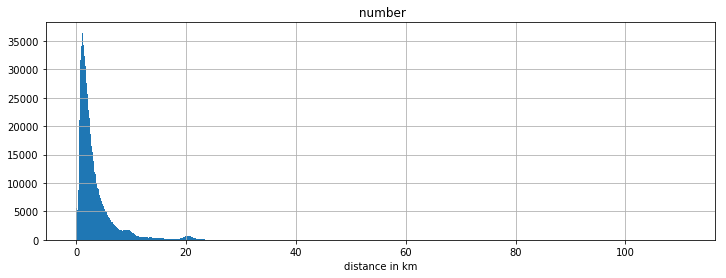

In [0]:
train_distance.distance.hist(bins=1000, figsize=(12,4))
plt.xlabel('distance in km')
plt.title(' number')
train_distance.distance.describe(percentiles=[0.25,0.5,0.75,0.99])

Remove the data with distance less than 10 meters

In [0]:
print('Old size: %d' % len(train_distance))
train_distance1 = train_distance[train_distance.distance>=0.01]
print('New size: %d' % len(train_distance1))

Old size: 967328
New size: 965415


Add new features according to distance: 0-1km, 1km-4km, 4km-15km, 15km~
For example: distance=13km
Feature: distance_1km=1, distance_4km=3, distance_15km=9

In [0]:
def distance_1km(row):
    if row['distance'] <1:
        return row['distance']
    else:
        return 1 
def distance_4km(row):
    if (row['distance'] >=1) and (row['distance'] <4):
        return row['distance']-1
    elif row['distance'] <1:
        return 0
    else:
        return 3
def distance_15km(row):
    if (row['distance'] >=4) and (row['distance'] <15):
        return row['distance']-4
    elif row['distance'] <4:
        return 0
    else:
        return 11  
def distance_long(row):
    if row['distance'] >=15:
        return row['distance']-15
    else:
        return 0  
 

def add_distance_filter_features(df):

    df['distance_1km']=df.apply (lambda x: distance_1km(x), axis=1)
    df['distance_4km']=df.apply (lambda x: distance_4km(x), axis=1)
    df['distance_15km']=df.apply (lambda x: distance_15km(x), axis=1)
    df['distance_long']=df.apply (lambda x: distance_long(x), axis=1)
 
    
    # Drop 'pickup_datetime' as we won't need it anymore
#     df = df.drop('pickup_datetime', axis=1)
    return df

add new features related to distance

In [0]:
train_distance2 = add_distance_filter_features(train_distance1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [0]:
test_distance2= add_distance_filter_features(test_distance)
print(train_distance2.shape,test_distance2.shape)
# print(train_distance2['distance'][20:40],train_distance2['distance_1km'][20:40],train_distance2['distance_4km'][20:40],train_distance2['distance_15km'][20:40],train_distance2['distance_long'][20:40])

(965415, 43) (9914, 42)


check features of train data

In [0]:
train_distance2.dtypes

fare_amount                           float64
pickup_longitude                      float64
pickup_latitude                       float64
dropoff_longitude                     float64
dropoff_latitude                      float64
passenger_count                         int64
year                                    int64
spring                                  int64
summer                                  int64
fall                                    int64
winter                                  int64
workday                                 int64
weekend                                 int64
night                                   int64
late_night                              int64
day_time                                int64
distance                              float64
NY_uptown_pickup_distance             float64
NY_uptown_dropoff_distance            float64
NY_midtown_pickup_distance            float64
NY_midtown_dropoff_distance           float64
NY_downtown_pickup_distance       

Remove features: get up and drop off of latitude and longitude

In [0]:
# clean
dropped_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','distance']
train_clean = train_distance2.drop(dropped_columns, axis=1)
test_clean = test_distance2.drop(dropped_columns , axis=1)

# peek data
train_clean.dtypes

fare_amount                           float64
passenger_count                         int64
year                                    int64
spring                                  int64
summer                                  int64
fall                                    int64
winter                                  int64
workday                                 int64
weekend                                 int64
night                                   int64
late_night                              int64
day_time                                int64
NY_uptown_pickup_distance             float64
NY_uptown_dropoff_distance            float64
NY_midtown_pickup_distance            float64
NY_midtown_dropoff_distance           float64
NY_downtown_pickup_distance           float64
NY_downtown_dropoff_distance          float64
JFK_pickup_distance                   float64
JFK_dropoff_distance                  float64
EWR_pickup_distance                   float64
EWR_dropoff_distance              

Extract the fare amount as y

In [0]:
train_df, validation_df = train_test_split(train_clean, test_size=0.10, random_state=1)
# Get labels
train_labels = train_df['fare_amount'].values
validation_labels = validation_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
validation_df = validation_df.drop(['fare_amount'], axis=1)

scaler

In [0]:
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
validation_df_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_clean)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Select model type and set related parameters

In [0]:
BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.0003
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))
adam = optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
history = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_df_scaled, validation_labels), 
                    shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 868873 samples, validate on 96542 samples
Epoch 1/20
868873/868873 [==============================] - 42s 48us/step - loss: 69.5087 - mean_absolute_error: 6.5791 - val_loss: 14.6385 - val_mean_absolute_error: 2.0748
Epoch 2/20
868873/868873 [==============================] - 39s 45us/step - loss: 12.8486 - mean_absolute_error: 1.9822 - val_loss: 12.1264 - val_mean_absolute_error: 1.9954
Epoch 3/20
868873/868873 [==============================] - 39s 45us/step - loss: 12.2963 - mean_absolute_error: 1.9498 - val_loss: 11.3661 - val_mean_absolute_error: 1.8795
Epoch 4/20
868873/868873 [==============================] - 39s 45us/step - loss: 12.0985 - mean_absolute_error: 1.9346 - val_loss: 11.4372 - val_mean_absolute_error: 1.8370
Epoch 5/20
868873/868873 [==============================] - 38s 43us/step - loss: 11.8917 - mean_absolute_error: 1.9197 - val_loss: 11.4081 - val_mean_absolute_error: 1.9028
Epoch 6/20
868873/868873 [=====

drawing loss and epoch diagram

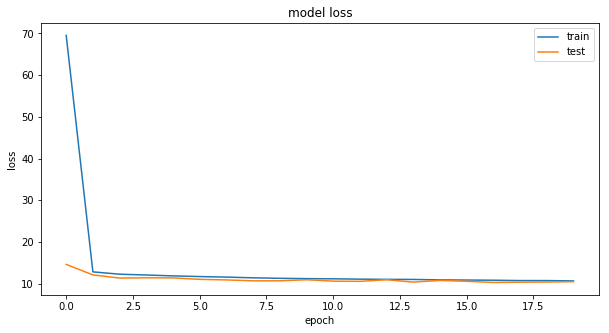

In [0]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Because the fare amount of test on kaggle is not available, so extract test data from train data, and predict test data

In [0]:
prediction = model.predict(train_df_scaled, batch_size=128, verbose=1)


868873/868873 [==============================] - 13s 14us/step


We assume that if the predict error is within 30% of the real price, the predict is accurate.

In [0]:
prediction=prediction.flatten()
accuracy_list=np.abs(prediction-train_labels)/train_labels
accuracy=np.mean(accuracy_list<0.30)
print(accuracy_list[:20])
print(accuracy)


[0.27249173 0.09233403 0.126237   0.14736319 0.06018993 0.10916719
 0.22483926 0.10258478 0.07251043 0.09637578 0.17969412 0.15825241
 0.13038989 0.10809241 0.0374755  0.17876499 0.11523229 0.19966091
 0.14734396 0.03410161]
0.8455861788776956


calculate the RMSE, it's about 3-3.3 and far less than original error$5-$8

In [0]:
accuracy_magnitude=np.sqrt(np.sum((prediction-train_labels)**2)/prediction.shape[0])
accuracy_magnitude

3.216165027970619